In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/amazon-fine-food-reviews/hashes.txt
/kaggle/input/amazon-fine-food-reviews/Reviews.csv
/kaggle/input/amazon-fine-food-reviews/database.sqlite


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.

Number of reviews: 568,454

Number of users: 256,059

Number of products: 74,258

Timespan: Oct 1999 - Oct 2012

Number of Attributes/Columns in data: 10

# Attribute Information:

Id

ProductId - unique identifier for the product

UserId - unqiue identifier for the user

ProfileName

HelpfulnessNumerator - number of users who found the review helpful

HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not

Score - rating between 1 and 5

Time - timestamp for the review

Summary - brief summary of the review

Text - text of the review

# Objective:
Given a review, determine whether the review is positive or negative.

Determine if the review is postive or negative:
We could use the Rating/score. A rating of 4 or 5 could be considered as positive review. A review of 1 or 2 could be considered as negative review and rating of 3 is considered as neutral and ignored. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.

# Loading the data
The dataset is available in two forms

1).csv file

2)SQLite Database

In order to load the data, I have used the SQLITE dataset as it easier to query the data and visualise the data efficiently.

In [3]:
# Importing required libraries

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
import re
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import stopwords

In [4]:
# using the SQLite Table to read data.
con = sqlite3.connect('../input/amazon-fine-food-reviews/database.sqlite') 

In [5]:
# filtering only positive and negative reviews i.e. not taking into consideration those reviews with Score=3

filtered_data = pd.read_sql_query("""
SELECT * FROM Reviews WHERE Score != 3""",con)

filtered_data.head(3)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


Here as I only want to get the global sentiment of the recommendations (positive or negative), I will purposefully ignore all Scores equal to 3. If the score id above 3, then the recommendation will be set to "positive" and if the score id below 3, then the recommendation it will be set to "negative".

In [6]:
# Give reviews with Score>3 a positive rating, and reviews with a score<3 a negative rating.
def seperate(x):
    if x > 3:
        return "positive"
    else:
        return "negative"
        
actual_score = filtered_data['Score']
positive_negative = actual_score.map(seperate)
filtered_data['Score'] = positive_negative

filtered_data.head(3)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,positive,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,negative,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,positive,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


# Exploratory Data Analysis

## Data Cleaning: Deduplication
It is necessary to remove duplicates in order to get unbiased results for the analysis of the data. 
Following is an example:

In [7]:
display = pd.read_sql_query("""SELECT * FROM Reviews WHERE Score!=3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductId""",con)
display

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As can be seen above the same user has multiple reviews of the with the same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that

ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [8]:
#Sorting data according to ProductId in ascending order
sorted_data = filtered_data.sort_values("ProductId", axis=0)
print(sorted_data.shape)
sorted_data.head(3)

(525814, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,positive,939340800,EVERY book is educational,this witty little book makes my son laugh at l...
138688,150506,0006641040,A2IW4PEEKO2R0U,Tracy,1,1,positive,1194739200,"Love the book, miss the hard cover version","I grew up reading these Sendak books, and watc..."
138689,150507,0006641040,A1S4A3IQ2MU7V4,"sally sue ""sally sue""",1,1,positive,1191456000,chicken soup with rice months,This is a fun way for children to learn their ...


In [9]:
# Deduplication of entries
final_sorted_data = sorted_data.drop_duplicates(subset={"UserId","Time","ProfileName","Text"}, keep='first', inplace=False)
print(final_sorted_data.shape)
final_sorted_data.head()

(364173, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,positive,939340800,EVERY book is educational,this witty little book makes my son laugh at l...
138688,150506,0006641040,A2IW4PEEKO2R0U,Tracy,1,1,positive,1194739200,"Love the book, miss the hard cover version","I grew up reading these Sendak books, and watc..."
138689,150507,0006641040,A1S4A3IQ2MU7V4,"sally sue ""sally sue""",1,1,positive,1191456000,chicken soup with rice months,This is a fun way for children to learn their ...
138690,150508,0006641040,AZGXZ2UUK6X,"Catherine Hallberg ""(Kate)""",1,1,positive,1076025600,a good swingy rhythm for reading aloud,This is a great little book to read aloud- it ...
138691,150509,0006641040,A3CMRKGE0P909G,Teresa,3,4,positive,1018396800,A great way to learn the months,This is a book of poetry about the months of t...


In [10]:
# Check how much % of data still remains after dropping duplicates and sorting
(final_sorted_data['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

69.25890143662969

# Observation:
It is observed that in two rows given below the value of HelpfulnessNumerator(number of users who found the review helpful) is greater than HelpfulnessDenominator(number of users who indicated whether they found the review helpful or not) which is not practically possible hence these two rows too are removed from calcualtions

In [11]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)
display

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [12]:
final = final_sorted_data[final_sorted_data["HelpfulnessNumerator"] <= final_sorted_data["HelpfulnessDenominator"]]
final.head(3)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,positive,939340800,EVERY book is educational,this witty little book makes my son laugh at l...
138688,150506,0006641040,A2IW4PEEKO2R0U,Tracy,1,1,positive,1194739200,"Love the book, miss the hard cover version","I grew up reading these Sendak books, and watc..."
138689,150507,0006641040,A1S4A3IQ2MU7V4,"sally sue ""sally sue""",1,1,positive,1191456000,chicken soup with rice months,This is a fun way for children to learn their ...


In [13]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

# positive and negative reviews counts
final['Score'].value_counts()

(364171, 10)


positive    307061
negative     57110
Name: Score, dtype: int64

# Text Preprocessing: Stemming, stop-word removal and Lemmatization.¶
Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

In Preprocessing step I am do following the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)

After which we collect the words used to describe positive and negative reviews

In [14]:
# find sentences containing HTML tags
i=0
for x in final['Text'].values:
    if (len(re.findall('<.*?>', x))):
        print(i)
        print(x)
        break;
    i += 1

6
I set aside at least an hour each day to read to my son (3 y/o). At this point, I consider myself a connoisseur of children's books and this is one of the best. Santa Clause put this under the tree. Since then, we've read it perpetually and he loves it.<br /><br />First, this book taught him the months of the year.<br /><br />Second, it's a pleasure to read. Well suited to 1.5 y/o old to 4+.<br /><br />Very few children's books are worth owning. Most should be borrowed from the library. This book, however, deserves a permanent spot on your shelf. Sendak's best.


In [15]:
# stoppwords
stop = set(stopwords.words('english'))

#initialising the snowball stemmer
snow = nltk.stem.SnowballStemmer('english') 

In [16]:
#function to clean the word of any html-tags
def cleanhtml(text):
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr,' ',text)
    return cleantext
#function to clean the word of any puntuations and special characters
def cleanpunc(text):
    cleantext = re.sub(r'[?|!|\'|#|\;|\"|~|^|.|,|/|\|)|(|/]',r'',text)
    return cleantext

In [17]:
# Lets see what are the stopwords and stemmed words
print(stop)
print('------------------------------------------------------------------------------')
print(snow.stem('borrowed'))

{'into', 'until', "needn't", 'yourself', 'll', 'your', 'few', "don't", 'above', 'while', 'shouldn', "doesn't", 'nor', 'shan', 'from', "mightn't", "you'll", 'about', "you've", 'at', 'through', 'who', 'y', "aren't", 'isn', "she's", 'other', "haven't", 'is', 'most', "couldn't", 'yours', 'don', "should've", 'over', 'each', 'here', 'it', 'by', 'more', 'm', 'wouldn', 'doing', 'than', 'against', 't', 'once', 'do', 'all', 'mustn', 'his', 'her', 'now', 'both', 'ma', 'my', 'himself', 'own', 'such', 'have', 'these', 'hasn', 'out', "won't", 'only', "didn't", "you're", 'no', 'very', 'their', 'again', 'ain', 'between', 'has', 'him', 'when', 'doesn', 'them', 'which', 'so', 'whom', 'yourselves', 'what', 'hers', 'if', 'having', "that'll", 'why', 'in', 'did', 'too', 'same', "mustn't", 'not', 'there', 'd', 'any', "you'd", "shan't", 's', 'am', 'of', 'to', 'how', 'just', 'where', "hadn't", 'ourselves', 'theirs', "weren't", 'didn', 'its', 'the', 'being', 'themselves', 'will', 'she', 've', 'me', 'aren', 'dur

In [18]:
#Code for implementing step-by-step the checks mentioned in the pre-processing phase
# this code takes a while to run as it needs to run on 500k sentences.
i=0
str1=' '
final_text=[]
all_positive_words=[] # store words from +ve reviews here
all_negative_words=[] # store words from -ve reviews here.
s=''
for x in final['Text'].values:
    filtered_sentence=[]

    x = cleanhtml(x) # remove HTMl tags
    for w in x.split():
        for cleaned_words in cleanpunc(w).split():
            
            if((cleaned_words.isalpha()) & (len(cleaned_words) > 2)):    
                if(cleaned_words.lower() not in stop):
                    s=(snow.stem(cleaned_words.lower())).encode('utf8')
                    filtered_sentence.append(s)
                    
                    if (final['Score'].values)[i] == 'positive': 
                        all_positive_words.append(s) #list of all words used to describe positive reviews
                        
                    if(final['Score'].values)[i] == 'negative':
                        all_negative_words.append(s) #list of all words used to describe negative reviews reviews
                
                else:
                    continue
            else:
                continue 
                
    str1 = b" ".join(filtered_sentence) #final string of cleaned words    
    final_text.append(str1)
    i+=1

In [19]:
# Adding an extra column of CleanedText which displays the data after pre-processing of the review
final['Cleaned Text'] = final_text

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [20]:
# store final table into an SQlLite table for future.
conn = sqlite3.connect('final.sqlite')
c=conn.cursor()
conn.text_factory = str
final.to_sql('Reviews', conn, schema=None, if_exists='replace', index=True, 
             index_label=None, chunksize=None, dtype=None)

/opt/conda/lib/python3.7/site-packages/pandas/core/generic.py:2789: UserWarning: The spaces in these column names will not be changed. In pandas versions < 0.14, spaces were converted to underscores.
  method=method,


# Bag of Words (BoW)


In [21]:
count_vect = CountVectorizer()
final_counts = count_vect.fit_transform(final['Text'].values)
final_counts.shape

(364171, 115281)

# Bi-Grams and n-Gram

Now that we have our list of words describing positive and negative reviews lets analyse them.

We begin analysis by getting the frequency distribution of the words as shown below

In [22]:
freq_pos_dist = nltk.FreqDist(all_positive_words)
freq_neg_dist = nltk.FreqDist(all_negative_words)

print("Most Common Positive Words : ",freq_pos_dist.most_common(10))
print("\nMost Common Negative Words : ",freq_neg_dist.most_common(10))

Most Common Positive Words :  [(b'like', 139110), (b'tast', 128274), (b'good', 112198), (b'flavor', 108922), (b'love', 107038), (b'use', 103648), (b'great', 103220), (b'one', 96589), (b'product', 90503), (b'tri', 86460)]

Most Common Negative Words :  [(b'tast', 34344), (b'like', 32231), (b'product', 28054), (b'one', 20527), (b'flavor', 19419), (b'would', 17947), (b'tri', 17695), (b'use', 15269), (b'good', 14937), (b'coffe', 14608)]


# Observation:
From the above it can be seen that the most common positive and the negative words overlap for eg. 'like' could be used as 'not like' etc.

Therfore, it is a good idea to consider pairs of consequent words (bi-grams) or q sequence of n consecutive words (n-grams)

In [23]:
# bi-gram, tri-gram and n-gram

count_vect = CountVectorizer(ngram_range=(1,2)) 
final_bigram_counts = count_vect.fit_transform(final['Text'].values)
final_bigram_counts.shape

(364171, 2910192)

# TF-IDF

In [24]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2))
final_tf_idf = tf_idf_vect.fit_transform(final['Text'].values)
final_tf_idf.shape

(364171, 2910192)

In [25]:
features = tf_idf_vect.get_feature_names()
len(features)

2910192

In [26]:
# Get top n tfidf values in row and return them with their corresponding feature names.
def top_tfidf_features(row, features, top_n=20):
    top_n_ids = np.argsort(row)[::-1][:top_n]
    top_features = [(features[i], row[i]) for i in top_n_ids]
    df = pd.DataFrame(top_features)
    df.columns = ['features', 'tfidf']
    return df

top_tfidf = top_tfidf_features(final_tf_idf[1,:].toarray()[0],features,20)
top_tfidf

,features,tfidf
0,sendak books,0.173437
1,rosie movie,0.173437
2,paperbacks seem,0.173437
3,cover version,0.173437
4,these sendak,0.173437
5,the paperbacks,0.173437
6,pages open,0.173437
7,really rosie,0.168074
8,incorporates them,0.168074
9,paperbacks,0.168074


In [27]:
# Training my own Word2Vec model using my own text corpus
import gensim
i=0
list_of_sent=[]
for sent in final['Text'].values:
    filtered_sentence=[]
    sent=cleanhtml(sent)
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if(cleaned_words.isalpha()):    
                filtered_sentence.append(cleaned_words.lower())
            else:
                continue 
    list_of_sent.append(filtered_sentence)

In [28]:
print(final['Text'].values[2])
print("-----------------------------------------------------------------------------------")
print(list_of_sent[0])

This is a fun way for children to learn their months of the year!  We will learn all of the poems throughout the school year.  they like the handmotions which I invent for each poem.
-----------------------------------------------------------------------------------
['this', 'witty', 'little', 'book', 'makes', 'my', 'son', 'laugh', 'at', 'loud', 'i', 'recite', 'it', 'in', 'the', 'car', 'as', 'were', 'driving', 'along', 'and', 'he', 'always', 'can', 'sing', 'the', 'refrain', 'hes', 'learned', 'about', 'whales', 'india', 'drooping', 'i', 'love', 'all', 'the', 'new', 'words', 'this', 'book', 'introduces', 'and', 'the', 'silliness', 'of', 'it', 'all', 'this', 'is', 'a', 'classic', 'book', 'i', 'am', 'willing', 'to', 'bet', 'my', 'son', 'will', 'still', 'be', 'able', 'to', 'recite', 'from', 'memory', 'when', 'he', 'is', 'in', 'college']


In [29]:
w2v_model = gensim.models.Word2Vec(list_of_sent, min_count=5, vector_size=50, workers=4)

In [30]:
words = list(w2v_model.wv.key_to_index)
print(len(words))

35308


In [31]:
# Lets see similar words to any give word
w2v_model.wv.most_similar('good')

[('decent', 0.8393465280532837),
 ('great', 0.8202368021011353),
 ('terrific', 0.7964966893196106),
 ('fantastic', 0.7818413972854614),
 ('fine', 0.7353372573852539),
 ('wonderful', 0.724716067314148),
 ('bad', 0.7220306992530823),
 ('fabulous', 0.7148797512054443),
 ('phenomenal', 0.7001005411148071),
 ('yummy', 0.6967931389808655)]

In [32]:
w2v_model.wv.most_similar('tasty')

[('tastey', 0.8872009515762329),
 ('yummy', 0.8576770424842834),
 ('filling', 0.8343415260314941),
 ('satisfying', 0.824067234992981),
 ('delicious', 0.820091962814331),
 ('flavorful', 0.7867749929428101),
 ('delish', 0.7749062180519104),
 ('addicting', 0.7655701637268066),
 ('tasteful', 0.752970814704895),
 ('nutritious', 0.7403947114944458)]

In [33]:
w2v_model.wv.most_similar('worst')

[('nastiest', 0.9081589579582214),
 ('best', 0.8261648416519165),
 ('greatest', 0.8031010627746582),
 ('sweetest', 0.7273766994476318),
 ('nicest', 0.7189784646034241),
 ('tastiest', 0.7068839073181152),
 ('smoothest', 0.7003611326217651),
 ('foulest', 0.694405198097229),
 ('terrible', 0.6850173473358154),
 ('disgusting', 0.6776770949363708)]

In [34]:
w2v_model.wv.most_similar('expensive')

[('costly', 0.9166552424430847),
 ('pricey', 0.8336492776870728),
 ('overpriced', 0.7528035044670105),
 ('pricy', 0.7385811805725098),
 ('economical', 0.7294102907180786),
 ('spendy', 0.7087774276733398),
 ('affordable', 0.6862033009529114),
 ('inexpensive', 0.6410409212112427),
 ('competitive', 0.6272280812263489),
 ('costs', 0.6238671541213989)]

# Avg W2V, TFIDF-W2V

In [35]:
# Avg Word2Vec

# computing average word2vec for each review.
sent_vectors = [] # the avg-w2v for each sentence/review is stored in this list
for sent in list_of_sent: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words = 0 # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
        except:
            pass
    sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in true_divide
  from ipykernel import kernelapp as app


364171
50


In [36]:
import pickle
pickle_avg_w2v = open("AvgW2V.pickle","wb")

pickle.dump(sent_vectors, pickle_avg_w2v) 
pickle_avg_w2v.close()

In [37]:
pickle_in = open("AvgW2V.pickle","rb")
sent_vectors = pickle.load(pickle_in)
avg_w2v = pd.DataFrame(sent_vectors)

# Standardization

In [38]:
# standardizing the data
from sklearn.preprocessing import StandardScaler
standardized_data = StandardScaler().fit_transform(avg_w2v)
print(standardized_data.shape)
type(standardized_data)

(364171, 50)


numpy.ndarray

# T-SNE Visualization

/opt/conda/lib/python3.7/site-packages/seaborn/axisgrid.py:316: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


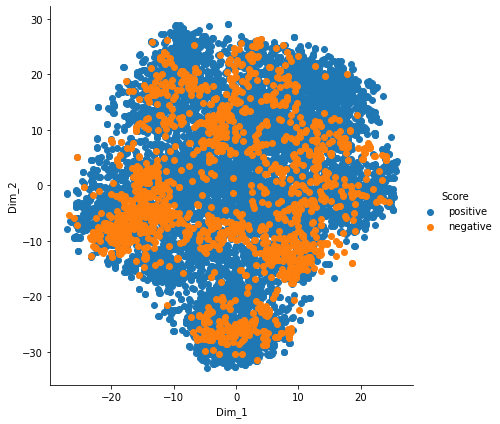

In [39]:
# With perplexity=30 and 10,000 datapoints
from sklearn.manifold import TSNE
import seaborn as sns

Scores = final['Score'].head(10000)
data_10000 = standardized_data[0:10000,:]
Scores_10000 = Scores

model = TSNE(n_components=2, random_state=0, perplexity=30, n_iter=500)

tsne_data = model.fit_transform(data_10000)

tsne_data = np.vstack((tsne_data.T, Scores_10000)).T

tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "Score"))

sns.FacetGrid(tsne_df, hue="Score", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.show()

/opt/conda/lib/python3.7/site-packages/seaborn/axisgrid.py:316: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


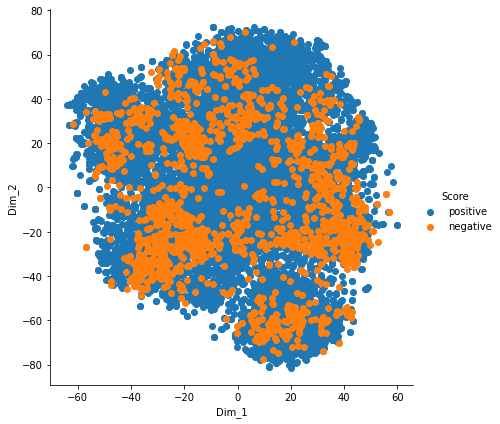

In [40]:
# With perplexity=20 and 10,000 datapoints
model = TSNE(n_components=2, random_state=0, perplexity=20, n_iter=1000)

tsne_data = model.fit_transform(data_10000)

tsne_data = np.vstack((tsne_data.T, Scores_10000)).T

tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "Score"))

sns.FacetGrid(tsne_df, hue="Score", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.show()

/opt/conda/lib/python3.7/site-packages/seaborn/axisgrid.py:316: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


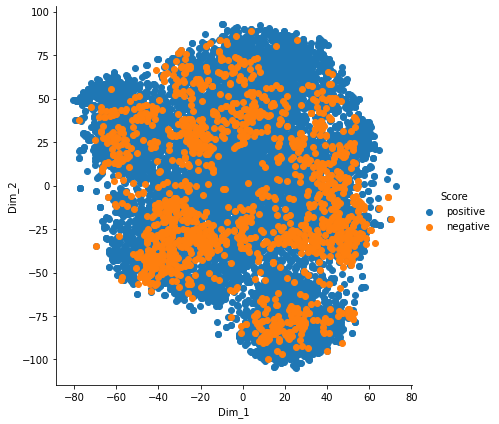

In [41]:
# With perplexity=40 and 10,000 datapoints
model = TSNE(n_components=2, random_state=0, perplexity=20, n_iter=1500)

tsne_data = model.fit_transform(data_10000)

tsne_data = np.vstack((tsne_data.T, Scores_10000)).T

tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "Score"))

sns.FacetGrid(tsne_df, hue="Score", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.show()

# T-SNE with tfidf

In [44]:
tfidf_final = final_tf_idf[0:500].toarray()
tfidf_data = pd.DataFrame(tfidf_final)
tfidf_data.shape

(500, 2910192)

In [ ]:
model = TSNE(n_components=2, random_state=0,perplexity=20,n_iter=250)

tsne_data = model.fit_transform(tfidf_data)

tsne_data = np.vstack((tsne_data.T, final['Score'].head(500))).T

tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "Score"))

sn.FacetGrid(tsne_df, hue="Score", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.show()

# Conclusion
In this notebook, I have plotted T-SNE for Average Word2Vec, TF-IDF , In all these T-SNE plots I was not able to classify positve and negative reviews into clusters.

## Note:
In Every method I have used subset of data as it is taking huge amount of time to execute on full data set.